### GAN

In [2]:
import os
#os.environ["CUDA_DEVICE_ERROR"] = "PCI_BUS_ID" #SELECT SPECIFIC GPU TO EXECUTE THIS MODEL
#os.environ['CUDA_VISIABLE_DEVICES'] = "1"

In [3]:
import numpy as np


import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, BatchNormalization, Dropout, Flatten
from keras.layers import Activation, Reshape, Conv2DTranspose, UpSampling2D
from keras.optimizers import RMSprop


import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
input_images = "../../data/apple.npy"
data = np.load(input_images)
data.shape

(144722, 784)

In [6]:
data[4343]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,  46,  69,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0, 163, 209,   0,   0,  46, 122, 171,  84,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0, 170, 207,  42, 171, 254, 255, 249,
        88,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0, 174, 232, 253, 255, 255,
       215,  50,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 178, 233, 255,
       255, 151,  10,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [12]:
data = data/ 255.0
data = np.reshape(data, (data.shape[0], 28, 28, 1))

img_w , img_h = data.shape[1:3]

In [13]:
data.shape

(144722, 28, 28, 1)

In [14]:
data[4343]

array([[[0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0

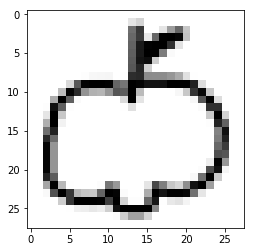

In [17]:
plt.imshow(data[4343, :, :, 0], cmap='Greys')

In [92]:
def discriminator_builder(width=64, p=0.4):
    
    #fdefine inputs:
    inputs = Input( (img_w, img_h, 1) )
    
    #convolutional layer
    
    conv1 = Conv2D(width*1, 5, strides=2, padding="same", activation='relu')(inputs)
    conv1 = Dropout(p)(conv1)
    
    conv2 = Conv2D(width*2, 5, strides=2, padding="same", activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    
    conv3 = Conv2D(width*4, 5, strides=2, padding="same", activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    
    conv4 = Conv2D(width*8, 5, strides=1, padding="same", activation='relu')(conv3)
    conv4 = Dropout(p)(conv4)
    
    conv4 = Flatten()(Dropout(p)(conv4))
    
    #outut
    output = Dense(1, activation='sigmoid')(conv4)
    
    #Model definition
    model = Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model

In [102]:
discriminator = discriminator_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_39 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_40 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_41 (Dropout)         (None, 4, 4, 256)         0         
__________

In [115]:
discriminator.compile(loss = 'binary_crossentropy',
                     optimizer=RMSprop(lr=0.008, decay = 6e-8, clipvalue=1.0),
                     metrics=['accuracy'])

In [116]:
def generator_builder(z_dim=100, width=64, p=0.4):
    
    #build the network
    inputs = Input( (z_dim,) )
    
    dense1 = Dense(7*7*64)(inputs)    
    dense1 = BatchNormalization(momentum=0.9)(dense1)
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,64))(dense1)
    dense1 = Dropout(p)(dense1)
    
    #deconvolutional layers:
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(width/2), kernel_size=5, padding = 'same', activation=None)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
    
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(width/4), kernel_size=5, padding = 'same', activation=None)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)
    
    conv3 = Conv2DTranspose(int(width/8), kernel_size=5, padding = 'same', activation=None)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)
    
    #output layer
    output = Conv2D(1, kernel_size = 5, padding='same', activation='sigmoid')(conv3)
    
    #Model definition
    model = Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model

In [117]:
generator = generator_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 100)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 3136)              316736    
_________________________________________________________________
batch_normalization_36 (Batc (None, 3136)              12544     
_________________________________________________________________
activation_36 (Activation)   (None, 3136)              0         
_________________________________________________________________
reshape_15 (Reshape)         (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d_26 (UpSampling (None, 14, 14, 64)        0         
__________

In [118]:
def adversarial_builder(z_dim=100):
    model = Sequential()
    model.add(generator_model)
    model.add(discriminator_model)
    
    model.compile(loss = 'binary_crossentropy',
                  optimizer = RMSprop(lr=0.0004, decay=3e-8, clipvalue=1.0),
                 metrics=['accuracy'])
    
    model.summary()
    
    return model

In [119]:
adversarial_model = adversarial_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_7 (Model)              (None, 28, 28, 1)         396961    
_________________________________________________________________
model_8 (Model)              (None, 1)                 4311553   
Total params: 4,708,514
Trainable params: 4,702,130
Non-trainable params: 6,384
_________________________________________________________________


In [120]:
def make_trainable(net, val):
    
    net.trainable = val
    for i in net.layers:
        i.trainable = val

In [121]:
def train(epochs=2000,batch=128):
    
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(epochs):
        
        if i%100 == 0:
            print(i)
        
        real_imgs = np.reshape(data[np.random.choice(data.shape[0],batch,replace=False)],(batch,28,28,1))
        fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, 100]))

        x = np.concatenate((real_imgs,fake_imgs))
        y = np.ones([2*batch,1])
        y[batch:,:] = 0
        
        make_trainable(discriminator, True)
        
        d_metrics.append(discriminator.train_on_batch(x,y))
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        
        make_trainable(discriminator, False)
        
        noise = np.random.uniform(-1.0, 1.0, size=[batch, 100])
        y = np.ones([batch,1])

        a_metrics.append(adversarial_model.train_on_batch(noise,y)) 
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        if (i+1)%500 == 0:

            print('Epoch #{}'.format(i+1))
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, size=[16, 100])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], cmap='gray')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    
    return a_metrics, d_metrics

0
100
200
300
400
Epoch #500
499: [D loss: 8.060438, acc: 0.500524]  [A loss: 0.001398, acc: 1.000579]


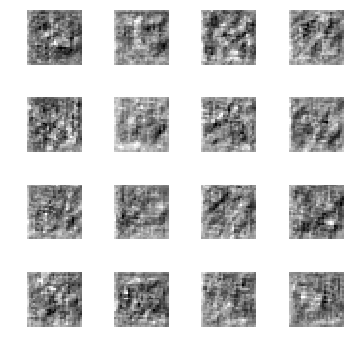

500
600
700
800
900


In [ ]:
a_metrics, d_metrics = train(epochs=3000)

In [ ]:
ax = pd.DataFrame(
    {
        'Generator': [metric[0] for metric in a_metrics_complete],
        'Discriminator': [metric[0] for metric in d_metrics_complete],
    }
).plot(title='Training Loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

In [ ]:
ax = pd.DataFrame(
    {
        'Generator': [metric[1] for metric in a_metrics_complete],
        'Discriminator': [metric[1] for metric in d_metrics_complete],
    }
).plot(title='Training Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")